<a href="https://colab.research.google.com/github/oceanumeric/NLP/blob/main/assignment1/exploring_word_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS224N Assignment 1: Exploring Word Vectors (25 Points)
### <font color='blue'> Due 3:15pm, Tue Jan 11 </font>

Welcome to CS224N! 

Before you start, make sure you read the README.txt in the same directory as this notebook for important setup information. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning :)

If you aren't super familiar with Python, Numpy, or Matplotlib, we recommend you check out the review session on Friday. The session will be recorded and the material will be made available on our [website](http://web.stanford.edu/class/cs224n/index.html#schedule). The CS231N Python/Numpy [tutorial](https://cs231n.github.io/python-numpy-tutorial/) is also a great resource.


**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [2]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.txt file found in the same directory as this notebook. Your Python version is " + python_version()
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In this case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

<div>
<img src="https://miro.medium.com/max/1400/0*arP2ZshqOKgXss-h.png" width="400">
</div>

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "grain" (i.e. news articles about corn, wheat, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [3]:
def read_corpus(category="grain"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


In [4]:
from zipfile import ZipFile
file_loc = '/root/nltk_data/corpora/reuters.zip'
with ZipFile(file_loc, 'r') as z:
  z.extractall('/root/nltk_data/corpora/')

Let's have a look what these documents are like….

In [5]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks',
  'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume',
  'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the',
  'china', 'daily', 'said', '.', 'it', 'also', 'said', 'that', 'each', 'year', '1', '.', '575',
  'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'china', "'", 's', 'fruit', 'output', 'are',
  'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30',
  'pct', ',', 'of', 'its', 'vegetables', '.', 'the', 'paper', 'blamed', 'the', 'waste', 'on',
  'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'it', 'said', 'the',
  'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', ',',
  'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', ',', 'and',
  'greater', 'production', 'of', 

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [6]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    flatten_list = [w for l in corpus for w in l]
    distinct_words = set(flatten_list)
    corpus_words = list(distinct_words)
    corpus_words = sorted(corpus_words)
    n_corpus_words = len(corpus_words)

    

    # ------------------

    return corpus_words, n_corpus_words

In [7]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [8]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = np.zeros((n_words, n_words))
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    for word in words:
      word2ind[word] = words.index(word)

    for sentence in corpus:
      sentence_len = len(sentence)
      for i in range(sentence_len):  # slice the window 
        center = sentence[i] 
        center_row_idex = word2ind[center]
        window_left = max(i-window_size, 0)
        window_right = min(i+window_size, sentence_len-1)
        for j in range(window_left, window_right+1):
          if j == i:
            continue
          else:
            context_word = sentence[j]
            context_word_col = word2ind[context_word]
            M[center_row_idex][context_word_col] += 1 


    # ------------------

    return M, word2ind

In [9]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [10]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    m_truncated_svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=167)
    M_reduced = m_truncated_svd.fit_transform(M)

    # ------------------

    print("Done.")
    return M_reduced

In [11]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)
print(M_test_reduced)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------
[[ 6.54802087e-01  7.83221122e-01]
 [ 5.20200324e-01  1.52655666e-15]
 [ 7.05647176e-01 -4.84057274e-01]
 [ 7.05647176e-01  4.84057274e-01]
 [ 1.02780472e+00  3.33066907e-16]
 [ 6.54802087e-01 -7.83221122e-01]
 [ 3.82258491e-01 -6.56224003e-01]
 [ 3.82258491e-01  6.56224003e-01]
 [ 1.39420808e+00  1.06179274e+00]
 [ 1.39420808e+00 -1.06179274e+00]]


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [12]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
      x = M_reduced[word2ind[word]][0]
      y = M_reduced[word2ind[word]][1]
      plt.scatter(x, y, color='red', marker='x')
      plt.text(x, y, word)
    
    plt.show()

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


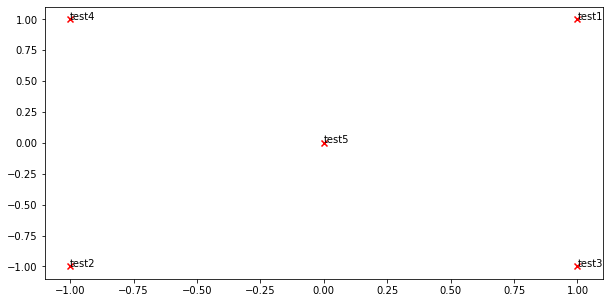

--------------------------------------------------------------------------------


In [13]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "grain" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?

Running Truncated SVD over 7146 words...
Done.
(7146, 2)


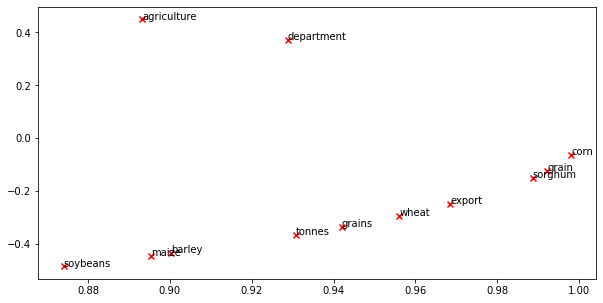

In [14]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
print(M_normalized.shape)

words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

In [15]:
print(M_reduced_co_occurrence.shape)
print(M_lengths.shape)
print(M_lengths[:, np.newaxis])

(7146, 2)
(7146,)
[[4.04558920e+02]
 [9.58782335e-01]
 [1.91852869e+00]
 ...
 [4.25762763e+00]
 [4.80786242e-02]
 [1.08511947e+00]]


#### <font color="red">Write your answer here.</font>


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [23]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index2word)))
    return wv_from_bin

In [24]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [25]:
def get_matrix_of_vectors(wv_from_bin, required_words=['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index2word)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [26]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

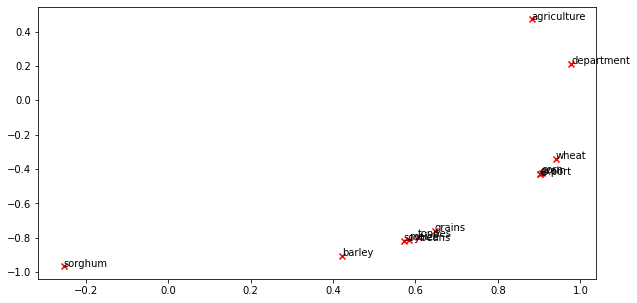

In [27]:
words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']
plot_embeddings(M_reduced_normalized, word2ind, words)

#### <font color="red">Write your answer here.</font>

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/assets/2b4a7a82-ad4c-4b2a-b808-e423a334de6f.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [30]:
# ------------------
# Write your implementation here.
wv_from_bin.most_similar('good')

# ------------------

[('better', 0.8141133785247803),
 ('really', 0.8016482591629028),
 ('always', 0.7913188338279724),
 ('sure', 0.7792829275131226),
 ('you', 0.7747212052345276),
 ('very', 0.7718809247016907),
 ('things', 0.7658981084823608),
 ('well', 0.7652329802513123),
 ('think', 0.7623050808906555),
 ('we', 0.7586264610290527)]

In [46]:
wv_from_bin.most_similar('apple', topn=20)

[('iphone', 0.6271389126777649),
 ('microsoft', 0.6061939001083374),
 ('intel', 0.5992331504821777),
 ('macintosh', 0.5989754796028137),
 ('ipod', 0.5908078551292419),
 ('ibm', 0.5888804793357849),
 ('ipad', 0.5876859426498413),
 ('software', 0.5711662769317627),
 ('google', 0.5554560422897339),
 ('itunes', 0.5478185415267944),
 ('pc', 0.5444667339324951),
 ('imac', 0.5354787111282349),
 ('computer', 0.5339134931564331),
 ('chips', 0.522017240524292),
 ('sony', 0.5184574127197266),
 ('apples', 0.5155556201934814),
 ('hewlett', 0.515369176864624),
 ('motorola', 0.5098389387130737),
 ('blackberry', 0.504676878452301),
 ('netscape', 0.49874329566955566)]

In [47]:
wv_from_bin.most_similar('samsung', topn=20)

[('lg', 0.7518872022628784),
 ('hyundai', 0.6675201654434204),
 ('panasonic', 0.6326290369033813),
 ('toshiba', 0.6170634031295776),
 ('sdi', 0.5919978618621826),
 ('electronics', 0.5833467245101929),
 ('fujitsu', 0.5766627192497253),
 ('nokia', 0.5727240443229675),
 ('nec', 0.5726516842842102),
 ('daewoo', 0.5581914186477661),
 ('posco', 0.5526381731033325),
 ('sony', 0.5516092777252197),
 ('lcd', 0.5484787821769714),
 ('motorola', 0.5425117611885071),
 ('hitachi', 0.5401551723480225),
 ('hynix', 0.5268266201019287),
 ('semiconductor', 0.5254107117652893),
 ('sanyo', 0.5145459175109863),
 ('philips', 0.5091080069541931),
 ('siemens', 0.5019107460975647)]

In [48]:
wv_from_bin.most_similar('huawei', topn=20)

[('zte', 0.7453933358192444),
 ('haier', 0.5662178993225098),
 ('lucent', 0.5372007489204407),
 ('alcatel', 0.5173822641372681),
 ('technologies', 0.511946439743042),
 ('nortel', 0.49590593576431274),
 ('uunet', 0.4814104437828064),
 ('unicom', 0.4682976007461548),
 ('telecom', 0.46594908833503723),
 ('cisco', 0.46284952759742737),
 ('lenovo', 0.4608071744441986),
 ('nokia', 0.4567490220069885),
 ('synagro', 0.4557429850101471),
 ('hcl', 0.4554169178009033),
 ('3com', 0.4532144069671631),
 ('datang', 0.4523051381111145),
 ('zhongxing', 0.4483164846897125),
 ('cae', 0.4449745714664459),
 ('motorola', 0.4417010247707367),
 ('siemens', 0.44124794006347656)]

In [50]:
wv_from_bin.most_similar('bmw', topn=20)

[('mercedes', 0.7167689800262451),
 ('audi', 0.6868889331817627),
 ('benz', 0.6840651035308838),
 ('volkswagen', 0.6554473042488098),
 ('renault', 0.6368719339370728),
 ('porsche', 0.6318350434303284),
 ('sauber', 0.6147507429122925),
 ('volvo', 0.5863637924194336),
 ('honda', 0.5849629640579224),
 ('ferrari', 0.5820727348327637),
 ('toyota', 0.579595685005188),
 ('vw', 0.5752115249633789),
 ('daimler', 0.5745106935501099),
 ('nissan', 0.5712559223175049),
 ('daimlerchrysler', 0.5703006982803345),
 ('5-series', 0.570095419883728),
 ('lexus', 0.5572115182876587),
 ('3-series', 0.5559712648391724),
 ('carmaker', 0.5429246425628662),
 ('peugeot', 0.5404567718505859)]

In [52]:
wv_from_bin.most_similar('geely', topn=20)

[('chery', 0.5816158056259155),
 ('volvo', 0.5516939759254456),
 ('haier', 0.5196852684020996),
 ('carmaker', 0.4901055097579956),
 ('zhejiang', 0.4656980633735657),
 ('baosteel', 0.4641824960708618),
 ('scania', 0.4582200348377228),
 ('byd', 0.4560743570327759),
 ('shufu', 0.44880571961402893),
 ('laiwu', 0.4468464255332947),
 ('baic', 0.4416654109954834),
 ('automaker', 0.4327748417854309),
 ('kelon', 0.42730188369750977),
 ('sinochem', 0.42506539821624756),
 ('lenovo', 0.4190436899662018),
 ('konka', 0.41628584265708923),
 ('ssangyong', 0.41331732273101807),
 ('ssab', 0.410785973072052),
 ('skf', 0.40726181864738464),
 ('arcelormittal', 0.4059547185897827)]

In [45]:
wv_from_bin.most_similar('honeywell')

[('ge', 0.7074675559997559),
 ('alliedsignal', 0.683214545249939),
 ('textron', 0.5751370191574097),
 ('westinghouse', 0.5264223217964172),
 ('lucent', 0.5230650901794434),
 ('trw', 0.5205550193786621),
 ('packard', 0.5146443843841553),
 ('caterpillar', 0.5071490406990051),
 ('motorola', 0.5055563449859619),
 ('alcoa', 0.5054365396499634)]

In [54]:
wv_from_bin.most_similar('tesla', topn=20)

[('motors', 0.5129432678222656),
 ('roadster', 0.4831695556640625),
 ('nikola', 0.4811766445636749),
 ('edison', 0.45055288076400757),
 ('isuzu', 0.4434756636619568),
 ('electric', 0.44116291403770447),
 ('volt', 0.44067317247390747),
 ('inventor', 0.4354279637336731),
 ('nvidia', 0.43264564871788025),
 ('wardenclyffe', 0.41840118169784546),
 ('ev1', 0.41791832447052),
 ('coil', 0.41244134306907654),
 ('coils', 0.38744261860847473),
 ('lamborghini', 0.38667115569114685),
 ('rechargeable', 0.38486722111701965),
 ('roadsters', 0.3818674385547638),
 ('g.m.', 0.380782812833786),
 ('plug-in', 0.37828201055526733),
 ('mazda', 0.3778231739997864),
 ('micron', 0.3718774914741516)]

In [58]:
wv_from_bin.most_similar('facebook', topn=20)

[('twitter', 0.8435289263725281),
 ('myspace', 0.8185950517654419),
 ('youtube', 0.7537194490432739),
 ('google', 0.671447217464447),
 ('blogs', 0.6526654958724976),
 ('linkedin', 0.6494942903518677),
 ('blog', 0.6467068195343018),
 ('web', 0.6389558911323547),
 ('website', 0.6388845443725586),
 ('zuckerberg', 0.6286188960075378),
 ('websites', 0.6250430345535278),
 ('users', 0.6207194328308105),
 ('networking', 0.6175296902656555),
 ('online', 0.6171836853027344),
 ('flickr', 0.6115960478782654),
 ('internet', 0.6040122509002686),
 ('yahoo', 0.592220664024353),
 ('blogging', 0.5804023742675781),
 ('instagram', 0.5770766735076904),
 ('skype', 0.5765348672866821)]

In [61]:
wv_from_bin.most_similar('h&m', topn=20)

[('c&a', 0.5070998668670654),
 ('sephora', 0.49876973032951355),
 ('topshop', 0.4913516044616699),
 ('zara', 0.4629468023777008),
 ('mexx', 0.4608934223651886),
 ('j.crew', 0.4538807272911072),
 ('fall/winter', 0.4476618766784668),
 ('matalan', 0.44641903042793274),
 ('superdrug', 0.44581952691078186),
 ('lancôme', 0.43919268250465393),
 ('bon-ton', 0.43673932552337646),
 ('debenhams', 0.4366729259490967),
 ('beachwear', 0.4332478940486908),
 ('ikea', 0.42957156896591187),
 ('anthropologie', 0.42599576711654663),
 ('jcpenney', 0.42297476530075073),
 ('spring/summer', 0.4206225275993347),
 ('burberry', 0.4167807102203369),
 ('bloomingdale', 0.41494256258010864),
 ('b&q', 0.41323769092559814)]

In [62]:
wv_from_bin.most_similar('nike', topn=20)

[('adidas', 0.7082109451293945),
 ('reebok', 0.6686112880706787),
 ('apparel', 0.560280978679657),
 ('swoosh', 0.5576590299606323),
 ('sneakers', 0.5547460317611694),
 ('sneaker', 0.5255051851272583),
 ('shoe', 0.49650344252586365),
 ('sportswear', 0.48064762353897095),
 ('footwear', 0.4795113205909729),
 ('sponsor', 0.475738525390625),
 ('puma', 0.47121673822402954),
 ('titleist', 0.46618494391441345),
 ('sponsorship', 0.46539974212646484),
 ('sponsors', 0.45128297805786133),
 ('beaverton', 0.45060625672340393),
 ('shoes', 0.44915324449539185),
 ('mart', 0.4453921318054199),
 ('brand', 0.4395320415496826),
 ('pepsi', 0.4256014823913574),
 ('motorola', 0.42476484179496765)]

In [63]:
wv_from_bin.most_similar('adidas', topn=20)

[('reebok', 0.719016432762146),
 ('nike', 0.7082109451293945),
 ('sportswear', 0.6800757646560669),
 ('puma', 0.5965368151664734),
 ('sneakers', 0.574507474899292),
 ('sneaker', 0.566622793674469),
 ('apparel', 0.5364523530006409),
 ('taylormade', 0.5222746133804321),
 ('footwear', 0.4954334497451782),
 ('shoes', 0.4892440736293793),
 ('speedo', 0.4886344373226166),
 ('ag', 0.48487311601638794),
 ('shoe', 0.4795190393924713),
 ('umbro', 0.4713866114616394),
 ('swimwear', 0.46423399448394775),
 ('volkswagen', 0.4501868486404419),
 ('polo', 0.4477965533733368),
 ('sponsorship', 0.44011086225509644),
 ('keds', 0.42604291439056396),
 ('jerseys', 0.42271751165390015)]

In [73]:
wv_from_bin.most_similar("ck", topn=20)

[('calvin', 0.4925266206264496),
 ('dkny', 0.45676925778388977),
 ('sportcenter', 0.4523279070854187),
 ('jeans', 0.4291590452194214),
 ('klein', 0.4112396836280823),
 ('dg', 0.40810394287109375),
 ('nayudu', 0.3829610347747803),
 ('moet', 0.38164272904396057),
 ('denim', 0.38109076023101807),
 ('warnaco', 0.37786275148391724),
 ('jeanswear', 0.37453794479370117),
 ('hennessy', 0.36960452795028687),
 ('karan', 0.3664029836654663),
 ('oce', 0.3659818768501282),
 ('sportswear', 0.3647208511829376),
 ('chandon', 0.3629071116447449),
 ('trillin', 0.358979731798172),
 ('underwear', 0.3541145622730255),
 ('fragrances', 0.3534366488456726),
 ('bagel', 0.3513495922088623)]

In [76]:
wv_from_bin.most_similar("converse", topn=20)

[('sneakers', 0.6077280640602112),
 ('sneaker', 0.46198609471321106),
 ('shoes', 0.42193007469177246),
 ('reebok', 0.41848674416542053),
 ('nike', 0.4166819155216217),
 ('adidas', 0.4110904932022095),
 ('socks', 0.4050147831439972),
 ('shoe', 0.40286409854888916),
 ('jeans', 0.3976730704307556),
 ('laces', 0.3787418007850647),
 ('sandals', 0.37468421459198),
 ('timberland', 0.3722640872001648),
 ('distinguish', 0.36227500438690186),
 ('florsheim', 0.3592531681060791),
 ('sweatshirts', 0.35544782876968384),
 ('boots', 0.3545383810997009),
 ('pants', 0.3540637493133545),
 ('hosiery', 0.35103699564933777),
 ('hightops', 0.34899306297302246),
 ('keds', 0.3473569452762604)]

In [77]:
wv_from_bin.most_similar('lacoste', topn=20)

[('lanvin', 0.4335879385471344),
 ('hermès', 0.4239671230316162),
 ('cochet', 0.4198978841304779),
 ('clément', 0.41267746686935425),
 ('rene', 0.4090011417865753),
 ('thierry', 0.4089953601360321),
 ('hermes', 0.4047155976295471),
 ('borotra', 0.4014361500740051),
 ('chemise', 0.39995336532592773),
 ('cartier', 0.3972025513648987),
 ('bardot', 0.39591115713119507),
 ('fernand', 0.3930252194404602),
 ('sportswear', 0.39102983474731445),
 ('izod', 0.3909556269645691),
 ('chanel', 0.38793283700942993),
 ('vuitton', 0.38586658239364624),
 ('beatrice', 0.3856257200241089),
 ('faasen', 0.38524433970451355),
 ('handbags', 0.3780166208744049),
 ('khakis', 0.3768294155597687)]

In [79]:
wv_from_bin.most_similar('uniqlo', topn=20)

[('mothercare', 0.4480432868003845),
 ('retailing', 0.4417460262775421),
 ('topshop', 0.42707157135009766),
 ('ready-to-wear', 0.4243854880332947),
 ('superdrug', 0.41490936279296875),
 ('mexx', 0.41237014532089233),
 ('apparel', 0.4038099944591522),
 ('aquos', 0.4026598036289215),
 ('amerisuites', 0.40242519974708557),
 ('supercenter', 0.4002472162246704),
 ('hennes', 0.39820295572280884),
 ('wertkauf', 0.3971702456474304),
 ('familymart', 0.39522767066955566),
 ('clothing', 0.3889542520046234),
 ('casual', 0.3872099220752716),
 ('fuddruckers', 0.3855218291282654),
 ('hypermarket', 0.3847671449184418),
 ('lenscrafters', 0.3843299150466919),
 ('hypermarkets', 0.3837728798389435),
 ('footwear', 0.3835541009902954)]

In [80]:
wv_from_bin.most_similar('muji', topn=20)

[('dollarama', 0.5677516460418701),
 ('fopp', 0.5252377986907959),
 ('save-a-lot', 0.5073984861373901),
 ('pust', 0.503294825553894),
 ('cafepress', 0.5014147758483887),
 ('robosapien', 0.4999891519546509),
 ('computerware', 0.4943494498729706),
 ('youth-team', 0.4933806359767914),
 ('sphodromantis', 0.4912043809890747),
 ('arandas', 0.4911457598209381),
 ('steffie', 0.4886452555656433),
 ('hhgregg', 0.4884582459926605),
 ('hoshihananomia', 0.4864780008792877),
 ('madewell', 0.484527587890625),
 ('fielea', 0.4841874837875366),
 ('amoria', 0.48407652974128723),
 ('amee', 0.48195064067840576),
 ('anisopodus', 0.4813452363014221),
 ('kathyrn', 0.4795258045196533),
 ('alamelu', 0.4795111417770386)]

In [81]:
wv_from_bin.most_similar('ikea', topn=20)

[('furnishings', 0.556840717792511),
 ('furniture', 0.5370278358459473),
 ('retailer', 0.5350003242492676),
 ('kamprad', 0.5214967727661133),
 ('appliance', 0.5039699077606201),
 ('furnishing', 0.5018892288208008),
 ('carrefour', 0.4853472113609314),
 ('mart', 0.48211804032325745),
 ('stores', 0.47267040610313416),
 ('store', 0.4651605486869812),
 ('homewares', 0.4645256996154785),
 ('walmart', 0.46368157863616943),
 ('tesco', 0.44564101099967957),
 ('showroom', 0.44497445225715637),
 ('ahold', 0.4435151517391205),
 ('starbucks', 0.4409845471382141),
 ('gome', 0.4393410384654999),
 ('nordstrom', 0.43830612301826477),
 ('housewares', 0.4370158910751343),
 ('sephora', 0.4353094696998596)]

In [82]:
wv_from_bin.most_similar('starbucks', topn=20)

[("dunkin'", 0.6544542908668518),
 ('donuts', 0.6264630556106567),
 ('coffee', 0.5818396806716919),
 ('7-eleven', 0.5697736144065857),
 ('mcdonalds', 0.5504791736602783),
 ('mcdonald', 0.5476234555244446),
 ('mart', 0.5473501682281494),
 ('stores', 0.5459513664245605),
 ('cafe', 0.5380913615226746),
 ('latte', 0.5291129350662231),
 ('store', 0.5187830924987793),
 ('coffeehouse', 0.5159116983413696),
 ('cola', 0.515746533870697),
 ('walgreens', 0.5145913362503052),
 ('grocery', 0.5108262896537781),
 ('costco', 0.5016781091690063),
 ('espresso', 0.5003819465637207),
 ('supermarket', 0.5002560019493103),
 ('burger', 0.4983474910259247),
 ('restaurants', 0.4975537657737732)]

In [88]:
wv_from_bin.most_similar('shein', topn=20)

[('abdullahi', 0.5094675421714783),
 ('mwinyi', 0.5089333653450012),
 ('shahbazi', 0.5017743110656738),
 ('macki', 0.4922594428062439),
 ('bedjaoui', 0.48187005519866943),
 ('abdulahi', 0.47975942492485046),
 ('cassim', 0.4737018942832947),
 ('jiachen', 0.4647853374481201),
 ('taha', 0.4621591567993164),
 ('samatar', 0.46127787232398987),
 ('hamzah', 0.4569692313671112),
 ('rachid', 0.4540257453918457),
 ('parviz', 0.451188862323761),
 ('abdellahi', 0.4502997398376465),
 ('sheni', 0.4491506814956665),
 ('zou', 0.44524067640304565),
 ('kahlah', 0.4451759457588196),
 ('ahmadou', 0.4397560954093933),
 ('kourouma', 0.4382806122303009),
 ('yoshihisa', 0.4374973773956299)]

#### <font color="red">Write your answer here.</font>

In [90]:
# get word vector and calculate distance
len(wv_from_bin['apple'])

200

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [91]:
# ------------------
# Write your implementation here.
wv_from_bin.distance('apple', 'samsung')
# ------------------

0.6302466988563538

In [94]:
wv_from_bin.distance('bmw', 'tesla')

0.7255839705467224

In [93]:
wv_from_bin.distance('apple', 'huawei')

0.7887519299983978

In [92]:
wv_from_bin.distance('apple', 'microsoft')

0.3938061594963074

#### <font color="red">Write your answer here.</font>

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [95]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608444690704346),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151535749435425),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.6446609497070312),
 ('wife', 0.6445354223251343)]


In [97]:
wv_from_bin.most_similar('bmw', topn=20)

[('mercedes', 0.7167689800262451),
 ('audi', 0.6868889331817627),
 ('benz', 0.6840651035308838),
 ('volkswagen', 0.6554473042488098),
 ('renault', 0.6368719339370728),
 ('porsche', 0.6318350434303284),
 ('sauber', 0.6147507429122925),
 ('volvo', 0.5863637924194336),
 ('honda', 0.5849629640579224),
 ('ferrari', 0.5820727348327637),
 ('toyota', 0.579595685005188),
 ('vw', 0.5752115249633789),
 ('daimler', 0.5745106935501099),
 ('nissan', 0.5712559223175049),
 ('daimlerchrysler', 0.5703006982803345),
 ('5-series', 0.570095419883728),
 ('lexus', 0.5572115182876587),
 ('3-series', 0.5559712648391724),
 ('carmaker', 0.5429246425628662),
 ('peugeot', 0.5404567718505859)]

In [99]:
wv_from_bin.most_similar('tesla', topn=20)

[('motors', 0.5129432678222656),
 ('roadster', 0.4831695556640625),
 ('nikola', 0.4811766445636749),
 ('edison', 0.45055288076400757),
 ('isuzu', 0.4434756636619568),
 ('electric', 0.44116291403770447),
 ('volt', 0.44067317247390747),
 ('inventor', 0.4354279637336731),
 ('nvidia', 0.43264564871788025),
 ('wardenclyffe', 0.41840118169784546),
 ('ev1', 0.41791832447052),
 ('coil', 0.41244134306907654),
 ('coils', 0.38744261860847473),
 ('lamborghini', 0.38667115569114685),
 ('rechargeable', 0.38486722111701965),
 ('roadsters', 0.3818674385547638),
 ('g.m.', 0.380782812833786),
 ('plug-in', 0.37828201055526733),
 ('mazda', 0.3778231739997864),
 ('micron', 0.3718774914741516)]

In [108]:
pprint.pprint(wv_from_bin.most_similar(positive=['tesla', 'electric'], topn=20))

[('motors', 0.6628822684288025),
 ('edison', 0.5562387704849243),
 ('volt', 0.552075207233429),
 ('motor', 0.5233665704727173),
 ('powered', 0.5075327157974243),
 ('generator', 0.4958832859992981),
 ('electrical', 0.48335257172584534),
 ('generators', 0.4827658236026764),
 ('ev1', 0.47071534395217896),
 ('utility', 0.46966060996055603),
 ('hydro', 0.46765753626823425),
 ('manufacturer', 0.4638749957084656),
 ('turbines', 0.4637964367866516),
 ('solid-body', 0.46288713812828064),
 ('rechargeable', 0.46252211928367615),
 ('electricity', 0.459147185087204),
 ('sanyo', 0.4552963376045227),
 ('westinghouse', 0.4528196156024933),
 ('ge', 0.4520060420036316),
 ('battery', 0.4470507502555847)]


Let $m$, $g$, $w$, and $x$ denote the word vectors for `man`, `grandfather`, `woman`, and the answer, respectively. Using **only** vectors $m$, $g$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `grandfather` and the answer?

#### <font color="red">Write your answer here.</font>

### Question 2.5: Finding Analogies [code + written]  (1.5 points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [110]:
# ------------------
# Write your implementation here.
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'king'], negative=['woman']))

# ------------------

[('prince', 0.5498569011688232),
 ('ii', 0.5442492365837097),
 ('brother', 0.5355215072631836),
 ('iii', 0.5316785573959351),
 ('reign', 0.5311692357063293),
 ('uncle', 0.5205864906311035),
 ('kingdom', 0.5030312538146973),
 ('henry', 0.4990271329879761),
 ('kings', 0.496202290058136),
 ('iv', 0.4810381531715393)]


#### <font color="red">Write your answer here.</font>

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [ ]:
# ------------------
# Write your implementation here.



# ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "girl" and "toy" and most dissimilar to "boy", and (b) which terms are most similar to "boy" and "toy" and most dissimilar to "girl". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [111]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'toy'], negative=['boy']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['boy', 'toy'], negative=['girl']))

[('toys', 0.7094953060150146),
 ('doll', 0.5932915210723877),
 ('dolls', 0.570662260055542),
 ('barbie', 0.5407705903053284),
 ('mattel', 0.5328551530838013),
 ('accessories', 0.52069091796875),
 ('hasbro', 0.4922722280025482),
 ('jewelry', 0.47385698556900024),
 ('lego', 0.4690813720226288),
 ('apparel', 0.461362361907959)]

[('toys', 0.7157087326049805),
 ('hasbro', 0.5164632797241211),
 ('robot', 0.4731711149215698),
 ('pet', 0.4670490026473999),
 ('manufacturer', 0.46681636571884155),
 ('mattel', 0.4582391381263733),
 ('lego', 0.45811760425567627),
 ('miniature', 0.4441472291946411),
 ('makers', 0.4429824650287628),
 ('manufactured', 0.44275349378585815)]


#### <font color="red">Write your answer here.</font>

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
# ------------------
# Write your implementation here.


# ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Write your answer here.</font>

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells). 
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. <font color='blue'> Make sure all your solutions especially the coding parts are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.